In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
import os
os.chdir('/content/drive/MyDrive/without/data')


In [ ]:
#B005X4PL1G
!pwd

/content/drive/MyDrive/without/data


In [ ]:
pip install --upgrade efficientnet-pytorch

  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16446 sha256=f371109a9379c740b4c276819d669f4cd56645481ac9cddf0bfe9b9dde2b1dcf
  Stored in directory: /root/.cache/pip/wheels/0e/cc/b2/49e74588263573ff778da58cc99b9c6349b496636a7e165be6
Successfully built efficientnet-pytorch


In [ ]:
"""Main method to train the model."""


#!/usr/bin/python

import argparse
import sys
import time
import numpy as np
from torch.utils.tensorboard import SummaryWriter
import torch
import torch.utils.data
from torch.utils.data import dataloader
import torchvision
from tqdm import tqdm as tqdm
import pdb
import time
import pickle
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure, imshow, axis
from matplotlib.image import imread
from matplotlib.ticker import MaxNLocator
import PIL
import datasets
import img_text_composition_models

Dress_time = []
shirt_time=[]
Top_time = []

torch.set_num_threads(3)



In [ ]:
def load_dataset(opt):
  """Loads the input datasets."""
  print('Reading dataset ', opt.dataset)
  if opt.dataset == 'fashioniq':
    trainset = datasets.FashionIQ(
        anno_dir=opt.root_dir.format('annotation'),
        image_dir=opt.root_dir.format('images'),
        split_dir=opt.root_dir.format('public_split'),
        category= ['dress'],
        split='train',
        transform=torchvision.transforms.Compose([
            torchvision.transforms.Resize(256),
            torchvision.transforms.RandomCrop(224),
            torchvision.transforms.RandomHorizontalFlip(),
            torchvision.transforms.ToTensor(),            
            torchvision.transforms.Normalize([0.485, 0.456, 0.406],
                                             [0.229, 0.224, 0.225])
        ]))
  else:
    print('Invalid dataset', opt.dataset)
    sys.exit()

  print('trainset size:', len(trainset))
  #print('testset size:', len(testset))
  return trainset


In [ ]:
def create_model_and_optimizer(opt, texts):
  """Builds the model and related optimizer."""
  print('Creating model and optimizer for', opt.model)
  if opt.model == 'imgonly':
    model = img_text_composition_models.SimpleModelImageOnly(
        texts, opt)
  elif opt.model == 'textonly':
    model = img_text_composition_models.SimpleModelTextOnly(
        texts, opt)
  elif opt.model == 'add':
    model = img_text_composition_models.Add(texts, opt)
  elif opt.model == 'concat':
    model = img_text_composition_models.Concat(texts, opt)
  elif opt.model == 'tirg':
    model = img_text_composition_models.TIRG(texts, opt)
  elif opt.model == 'tirg_lastconv':
    model = img_text_composition_models.TIRGLastConv(
        texts, opt)
  else:
    print('Invalid model', opt.model)
    print('available: imgonly, textonly, add, concat, tirg, tirg_lastconv')
    sys.exit()
  model = model.cuda()
  #model = model
  
  # create optimizer
  params = []
  per_params = []
  for name, param in model.named_parameters():
    per_params.append(param)
  params.append({'params': per_params})
  if opt.optimizer == 'SGD':
    optimizer = torch.optim.SGD(
        params, lr=opt.learning_rate, momentum=0.9, weight_decay=opt.weight_decay)
  elif opt.optimizer == 'Adam':
    optimizer = torch.optim.Adam(params, lr=opt.learning_rate)
  return model, optimizer


def train_loop(opt, logger, trainset, model, optimizer, DP_data=None):
  """Function for train loop"""
  print('Begin training')
  losses_tracking = {}
  best_eval = 0
  it = 0
  tic = time.time()
  df_loss=pd.DataFrame(columns=["epoch","batch_based_classification", "total training loss"])
  df_R_mean_TextOnly=pd.DataFrame(columns=["epoch","Recall_Mean"])
  for epoch in range(opt.num_epoch):
    # run trainning for 1 epoch
    model.train()
    
    trainloader = dataloader.DataLoader(trainset,
        batch_size=opt.batch_size,
        shuffle=True,
        drop_last=True,
        num_workers=opt.loader_num_workers)
    
    def training_1_iter(data, data_dp=None):
      # img1 = data['source_img_data']
      # img2 = data['target_img_data']
     
      img1 = data['source_img_data'].cuda()
      img2 = data['target_img_data'].cuda()
      mods = data['mod']['str']

      # compute loss
      losses = []
      if opt.loss == 'batch_based_classification':
        loss_value = model.compute_loss(
            img1, mods, img2, soft_triplet_loss=False)
      else:
        print('Invalid loss function', opt.loss)
        sys.exit()
      loss_name = opt.loss
      loss_weight = 1.0
      losses += [(loss_name, loss_weight, loss_value)]

      total_loss = sum([
          loss_weight * loss_value
          for loss_name, loss_weight, loss_value in losses
      ])
      assert not torch.isnan(total_loss)
      losses += [('total training loss', None, total_loss)]

      # track losses
      for loss_name, loss_weight, loss_value in losses:
        if not loss_name in losses_tracking:
          losses_tracking[loss_name] = []
        losses_tracking[loss_name].append(float(loss_value))
    
      # gradient descend
      optimizer.zero_grad()
      total_loss.backward()
      optimizer.step()
    
    count_dp_idx = 0
    for data in tqdm(trainloader, desc='Training for epoch ' + str(epoch)):
      it = it + 1
      training_1_iter(data)
    
    # show/log stats
    print('It', it, 'epoch', epoch, 'Elapsed time', round(time.time() - tic, 4))
    tic = time.time()
    for loss_name in losses_tracking:
      avg_loss = np.mean(losses_tracking[loss_name][-len(trainloader):])
      if loss_name=="batch_based_classification":
        batch_loss=round(avg_loss, 5)
      else:
        training_loss=round(avg_loss, 5)
      print('    Loss', loss_name, round(avg_loss, 4))

    row=[epoch,batch_loss,training_loss]
    df_loss.loc[epoch] = row

    # test
    if epoch % opt.eval_frequency == 0:
      tests = []
      all_sims = {}
      rsum = 0
      for dataname in trainset.data_name:
        t, sims, nn_result = testResults(opt, model, trainset, dataname)
        all_sims[dataname] = sims
        for metric_name, metric_value in t:
          tests += [(metric_name, metric_value)]
          rsum += metric_value
      tests += [('rmean', rsum / 6)]
      for metric_name, metric_value in tests:
        logger.add_scalar(metric_name, metric_value, it)
        if metric_name=="rmean":
          row=[epoch,metric_value]
          df_R_mean_TextOnly.loc[epoch]=row
        print('    ', metric_name, round(metric_value, 2))

      if rsum > best_eval:
        best_eval = rsum
        # save checkpoint
        for dataname in trainset.data_name:
          np.save(opt.log_dir + '/val.{}.{}.scores.npy'.format(dataname, opt.model), all_sims[dataname])
        torch.save({
            'it': it,
            'opt': opt,
            'model_state_dict': model.state_dict(),
        },
        logger.file_writer.get_logdir() + '/best_checkpoint.pth')
  print('Finished training')
  return df_loss, df_R_mean_TextOnly
  

In [ ]:
def test(opt, testset, model):
  print('Begin testing')
  tests = []
  rsum = 0
  for dataname in testset.data_name:
    t, sims, nn_result = testResults(opt, model, testset, dataname)
    np.save(opt.log_dir + '/val.{}.{}.scores.npy'.format(dataname, opt.model), sims)
    
    for metric_name, metric_value in t:
      tests += [(metric_name, metric_value)]
      rsum += metric_value

  tests += [('RecallMean', rsum / 6)]
  for metric_name, metric_value in tests:
    print('    ', metric_name, round(metric_value, 2))
  print('Finished testing')
  return nn_result

def load_state_dicts(opt, model):
  state_dict = torch.load(opt.resume_file, map_location=lambda storage, loc: storage)['model_state_dict']
  num_resumed_vars = 0
  own_state_dict = model.state_dict()
  new_state_dict = {}
  for varname, varvalue in state_dict.items():
    if varname in own_state_dict:
      new_state_dict[varname] = varvalue
      num_resumed_vars += 1
  own_state_dict.update(new_state_dict)
  model.load_state_dict(own_state_dict)
  print('number of resumed variables: {}'.format(num_resumed_vars))



In [ ]:
"""Evaluates the retrieval model."""
# A fuction to calculate evaluation metrics refere it.

dataname2id = {'dress': 0, 'shirt': 1, 'toptee': 2}
datanames = ['dress', 'shirt', 'toptee']

def testResults(opt, model, testset, dataname):
  """Tests a model over the given testset."""
  model.eval()
  dataname_id = dataname2id[dataname]
  test_queries = testset.get_test_queries()[dataname_id]
  test_targets = testset.get_test_targets()[dataname_id]

  all_queries = []
  all_imgs = []
  if test_queries:
    # compute test query features
    imgs = []
    mods = []
    for t in tqdm(test_queries):
      imgs += [t['source_img_data']]
      mods += [t['mod']['str']]
      if len(imgs) >= opt.batch_size or t is test_queries[-1]:
        if 'torch' not in str(type(imgs[0])):
          imgs = [torch.from_numpy(d).float() for d in imgs]
        imgs = torch.stack(imgs).float().cuda()
	#   imgs = torch.stack(imgs).float()
        f = model.compose_img_text(imgs, mods).data.cpu().numpy()
        all_queries += [f]
        imgs = []
        mods = []
    all_queries = np.concatenate(all_queries)
    
    # compute all image features
    imgs = []
    logits = []
    for t in tqdm(test_targets):
      imgs += [t['target_img_data']]
      if len(imgs) >= opt.batch_size or t is test_targets[-1]:
        if 'torch' not in str(type(imgs[0])):
          imgs = [torch.from_numpy(d).float() for d in imgs]
        imgs = torch.stack(imgs).float().cuda()
	#imgs = torch.stack(imgs).float()
        imgs = model.extract_img_feature(imgs).data.cpu().numpy()
        all_imgs += [imgs]
        imgs = []
    all_imgs = np.concatenate(all_imgs)
    
  # feature normalization
  for i in range(all_queries.shape[0]):
    all_queries[i, :] /= np.linalg.norm(all_queries[i, :])
  for i in range(all_imgs.shape[0]):
    all_imgs[i, :] /= np.linalg.norm(all_imgs[i, :])

  # match test queries to target images, get nearest neighbors
  sims = all_queries.dot(all_imgs.T)
  #print(sims)

  for i, t in enumerate(test_queries):
    sims[i, t['source_img_id']] = -10e10  # remove query image

  nn_result = [np.argsort(-sims[i, :])[:50] for i in range(sims.shape[0])]

  # compute recalls
  out = []
  for k in [1, 3, 5, 10, 20, 50]:
    r = 0.0
    for i, nns in enumerate(nn_result):
      if test_queries[i]['target_img_id'] in nns[:k]:
        r += 1
    r = 100 * r / len(nn_result)
    out += [('{}_r{}'.format(dataname, k), r)]
  return out, sims, nn_result

In [ ]:
def show_source(source_id):
  image_dir=opt.root_dir.format('images')
  fig = figure(figsize = (8,8))
  idx = test_queries[source_id]['source_img']
  img_path = image_dir + '/' +idx+ ".jpg"
  print("Textual Query =  ", test_queries[source_id]['mod']['str'].replace("<BOS>", " ").replace("<EOS>", " "))
  a=fig.add_subplot(1,2,1)
  image = imread(img_path)
  imshow(image)
  plt.title('Qurey Image')
  axis('off')

  idx = test_queries[source_id]['target_img']
  img_path = image_dir + '/' +idx+ ".jpg"

  a=fig.add_subplot(1,2,2)
  image = imread(img_path)
  imshow(image)
  plt.title('Target Image')
  axis('off')


In [ ]:

def get_result(array_list):
  result_files = []
  print(len(array_list))
  for i in range(len(array_list)):
    for t in test_queries:
      if t['source_img_id']==array_list[i]:
        idx = t['source_img']
        image_dir=opt.root_dir.format('images')
        img_path = image_dir + '/' +idx+ ".jpg"
        result_files += [img_path]
    
  return result_files
def show_result_all(result_files):
    
    
    fig = figure(figsize = (25,25))
    number_of_files = len(result_files)
    
    for i in range(5):
        a=fig.add_subplot(1,5,i+1)
        image = imread(result_files[i])
        imshow(image)
        if i==4:
          plt.title("Results ")
        axis('off')
    

# **Text Only Model**

In [ ]:
def parse_opt():
  """Parses the input arguments."""
  parser = argparse.ArgumentParser()
  parser.add_argument('-f', type=str, default='')
  parser.add_argument('--dataset', type=str, default='fashioniq')
  parser.add_argument('--root_dir', type=str, default='./{}')
  parser.add_argument('--log_dir', type=str, default='./runs')
  parser.add_argument('--model', type=str, default='textonly')
  parser.add_argument('--img_encoder', type=str, default='efficientnet')
  parser.add_argument('--text_encoder', type=str, default='lstm')
  parser.add_argument('--embed_dim', type=int, default=1024)
  parser.add_argument('--optimizer', type=str, default='Adam') # SGD Adam
  parser.add_argument('--learning_rate', type=float, default=1e-4)
  parser.add_argument(
      '--learning_rate_decay_patient', type=int, default=5)
  parser.add_argument('--eval_frequency', type=int, default=1)
  parser.add_argument('--lr_div', type=float, default=0.5) # 0.1
  parser.add_argument('--batch_size', type=int, default=32)
  parser.add_argument('--weight_decay', type=float, default=1e-6)
  parser.add_argument('--num_epoch', type=int, default=15)
  parser.add_argument('--loss', type=str, default='batch_based_classification')
  parser.add_argument('--loader_num_workers', type=int, default=4)
  parser.add_argument('--resume_file', default='./runs/best_checkpoint.pth')
  
  args = parser.parse_args()
  return args


In [ ]:
opt = parse_opt()
print('Arguments:')
for k in opt.__dict__.keys():
    print('    ', k, ':', str(opt.__dict__[k]))

Arguments:
     f : /root/.local/share/jupyter/runtime/kernel-af7a90ca-57cc-483d-afc2-34d5d96681cc.json
     dataset : fashioniq
     root_dir : ./{}
     log_dir : ./runs
     model : textonly
     img_encoder : efficientnet
     text_encoder : lstm
     embed_dim : 1024
     optimizer : Adam
     learning_rate : 0.0001
     learning_rate_decay_patient : 5
     eval_frequency : 1
     lr_div : 0.5
     batch_size : 32
     weight_decay : 1e-06
     num_epoch : 15
     loss : batch_based_classification
     loader_num_workers : 4
     resume_file : ./runs/best_checkpoint.pth


# Training

In [ ]:
logger = SummaryWriter(opt.log_dir)
print('Log files saved to', logger.file_writer.get_logdir())
for k in opt.__dict__.keys():
  logger.add_text(k, str(opt.__dict__[k]))
    
trainset = load_dataset(opt)

Log files saved to ./runs


In [ ]:
pickle_out = open("trainset_dress.pickle","wb")
pickle.dump(trainset, pickle_out)

pickle_in = open("trainset_dress.pickle","rb")
trainset = pickle.load(pickle_in)

In [ ]:
trainset_test_queries = trainset.get_test_queries()[0]
print(len(trainset_test_queries))

780


In [ ]:
model, optimizer = create_model_and_optimizer(opt, None)

start_time = time.time()
df_loss_TextOnly, df_R_mean_TextOnly= train_loop(opt, logger, trainset, model, optimizer)    
Dress_time.append(time.time() - start_time)
logger.close()
df_loss_TextOnly.head()

Creating model and optimizer for textonly
Loaded pretrained weights for efficientnet-b0


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Begin training


Training for epoch 0: 100%|██████████| 187/187 [06:19<00:00,  2.03s/it]


It 187 epoch 0 Elapsed time 379.5701
    Loss batch_based_classification 3.1507
    Loss total training loss 3.1507


100%|██████████| 4197/4197 [00:25<00:00, 166.25it/s]


     dress_r1 0.9
     dress_r3 2.82
     dress_r5 4.62
     dress_r10 6.79
     dress_r20 11.54
     dress_r50 20.9
     rmean 7.93


Training for epoch 1: 100%|██████████| 187/187 [02:19<00:00,  1.34it/s]


It 374 epoch 1 Elapsed time 168.0057
    Loss batch_based_classification 2.392
    Loss total training loss 2.392


100%|██████████| 4197/4197 [00:25<00:00, 166.76it/s]


     dress_r1 2.18
     dress_r3 6.28
     dress_r5 9.36
     dress_r10 14.62
     dress_r20 23.33
     dress_r50 37.18
     rmean 15.49


Training for epoch 2: 100%|██████████| 187/187 [02:19<00:00,  1.34it/s]


It 561 epoch 2 Elapsed time 165.9029
    Loss batch_based_classification 1.9758
    Loss total training loss 1.9758


100%|██████████| 4197/4197 [00:25<00:00, 167.34it/s]


     dress_r1 3.85
     dress_r3 8.85
     dress_r5 11.79
     dress_r10 19.49
     dress_r20 27.82
     dress_r50 44.62
     rmean 19.4


Training for epoch 3: 100%|██████████| 187/187 [02:18<00:00,  1.35it/s]


It 748 epoch 3 Elapsed time 165.4691
    Loss batch_based_classification 1.6782
    Loss total training loss 1.6782


100%|██████████| 4197/4197 [00:25<00:00, 166.81it/s]


     dress_r1 6.54
     dress_r3 13.97
     dress_r5 20.13
     dress_r10 30.0
     dress_r20 41.79
     dress_r50 59.49
     rmean 28.65


Training for epoch 4: 100%|██████████| 187/187 [02:19<00:00,  1.34it/s]


It 935 epoch 4 Elapsed time 165.9617
    Loss batch_based_classification 1.465
    Loss total training loss 1.465


100%|██████████| 4197/4197 [00:25<00:00, 167.22it/s]


     dress_r1 8.46
     dress_r3 16.79
     dress_r5 22.82
     dress_r10 34.62
     dress_r20 46.79
     dress_r50 66.41
     rmean 32.65


Training for epoch 5: 100%|██████████| 187/187 [02:18<00:00,  1.35it/s]


It 1122 epoch 5 Elapsed time 165.598
    Loss batch_based_classification 1.2799
    Loss total training loss 1.2799


100%|██████████| 4197/4197 [00:25<00:00, 166.79it/s]


     dress_r1 12.69
     dress_r3 22.69
     dress_r5 29.62
     dress_r10 45.38
     dress_r20 59.1
     dress_r50 77.56
     rmean 41.18


Training for epoch 6: 100%|██████████| 187/187 [02:19<00:00,  1.34it/s]


It 1309 epoch 6 Elapsed time 165.8348
    Loss batch_based_classification 1.1062
    Loss total training loss 1.1062


100%|██████████| 4197/4197 [00:25<00:00, 167.32it/s]


     dress_r1 17.05
     dress_r3 28.85
     dress_r5 37.31
     dress_r10 51.79
     dress_r20 65.77
     dress_r50 82.31
     rmean 47.18


Training for epoch 7: 100%|██████████| 187/187 [02:19<00:00,  1.34it/s]


It 1496 epoch 7 Elapsed time 165.7045
    Loss batch_based_classification 0.9756
    Loss total training loss 0.9756


100%|██████████| 4197/4197 [00:25<00:00, 166.82it/s]


     dress_r1 21.41
     dress_r3 37.44
     dress_r5 46.67
     dress_r10 60.77
     dress_r20 74.23
     dress_r50 88.97
     rmean 54.91


Training for epoch 8: 100%|██████████| 187/187 [02:18<00:00,  1.35it/s]


It 1683 epoch 8 Elapsed time 165.6683
    Loss batch_based_classification 0.856
    Loss total training loss 0.856


100%|██████████| 4197/4197 [00:25<00:00, 167.15it/s]


     dress_r1 27.69
     dress_r3 42.69
     dress_r5 51.03
     dress_r10 65.0
     dress_r20 77.95
     dress_r50 91.41
     rmean 59.29


Training for epoch 9: 100%|██████████| 187/187 [02:18<00:00,  1.35it/s]


It 1870 epoch 9 Elapsed time 165.69
    Loss batch_based_classification 0.7498
    Loss total training loss 0.7498


100%|██████████| 4197/4197 [00:25<00:00, 166.74it/s]


     dress_r1 26.79
     dress_r3 47.56
     dress_r5 56.54
     dress_r10 71.67
     dress_r20 81.28
     dress_r50 93.46
     rmean 62.88


Training for epoch 10: 100%|██████████| 187/187 [02:19<00:00,  1.34it/s]


It 2057 epoch 10 Elapsed time 165.9089
    Loss batch_based_classification 0.6438
    Loss total training loss 0.6438


100%|██████████| 4197/4197 [00:25<00:00, 167.52it/s]


     dress_r1 37.56
     dress_r3 54.49
     dress_r5 65.51
     dress_r10 77.69
     dress_r20 87.18
     dress_r50 96.79
     rmean 69.87


Training for epoch 11: 100%|██████████| 187/187 [02:19<00:00,  1.34it/s]


It 2244 epoch 11 Elapsed time 165.8732
    Loss batch_based_classification 0.5764
    Loss total training loss 0.5764


100%|██████████| 4197/4197 [00:25<00:00, 166.52it/s]


     dress_r1 40.26
     dress_r3 61.67
     dress_r5 69.62
     dress_r10 82.18
     dress_r20 91.41
     dress_r50 97.69
     rmean 73.8


Training for epoch 12: 100%|██████████| 187/187 [02:18<00:00,  1.35it/s]


It 2431 epoch 12 Elapsed time 165.737
    Loss batch_based_classification 0.5146
    Loss total training loss 0.5146


100%|██████████| 4197/4197 [00:25<00:00, 167.11it/s]


     dress_r1 45.9
     dress_r3 67.82
     dress_r5 75.77
     dress_r10 86.03
     dress_r20 93.72
     dress_r50 98.59
     rmean 77.97


Training for epoch 13: 100%|██████████| 187/187 [02:18<00:00,  1.35it/s]


It 2618 epoch 13 Elapsed time 165.6501
    Loss batch_based_classification 0.4644
    Loss total training loss 0.4644


100%|██████████| 4197/4197 [00:25<00:00, 166.72it/s]


     dress_r1 49.49
     dress_r3 71.41
     dress_r5 78.85
     dress_r10 89.23
     dress_r20 96.15
     dress_r50 99.36
     rmean 80.75


Training for epoch 14: 100%|██████████| 187/187 [02:19<00:00,  1.34it/s]


It 2805 epoch 14 Elapsed time 165.8875
    Loss batch_based_classification 0.4257
    Loss total training loss 0.4257


100%|██████████| 4197/4197 [00:25<00:00, 166.95it/s]


     dress_r1 54.87
     dress_r3 75.77
     dress_r5 83.08
     dress_r10 91.92
     dress_r20 97.05
     dress_r50 99.74
     rmean 83.74
Finished training


,epoch,batch_based_classification,total training loss
0,0.0,3.15068,3.15068
1,1.0,2.39201,2.39201
2,2.0,1.97576,1.97576
3,3.0,1.67820,1.67820
4,4.0,1.46495,1.46495


In [ ]:
df_R_mean_TextOnly

,epoch,Recall_Mean
0,0.0,7.927350
1,1.0,15.491453
2,2.0,19.401709
3,3.0,28.653846
4,4.0,32.649573
5,5.0,41.175214
6,6.0,47.179487
7,7.0,54.914530
8,8.0,59.294872
9,9.0,62.884615


In [ ]:
Dress_time

[2729.2275133132935]

# **Testing**

In [ ]:
#tmp_split = 'val'
tmp_split = 'test'
    
testset = datasets.FashionIQ(
    anno_dir=opt.root_dir.format('annotation'),
    image_dir=opt.root_dir.format('images'),
    split_dir=opt.root_dir.format('public_split'),
    category= ['dress'],
    split=tmp_split,
    transform=torchvision.transforms.Compose([
                                              torchvision.transforms.Resize(256),
                                              torchvision.transforms.CenterCrop(224),
                                              torchvision.transforms.ToTensor(),
                                              torchvision.transforms.Normalize([0.485, 0.456, 0.406],[0.229, 0.224, 0.225])
                                              ]
                                             )
    )

captions size 2017


In [ ]:
pickle_out1 = open("testset_dress.pickle","wb")
pickle.dump(testset, pickle_out1)

pickle_in1 = open("testset_dress.pickle","rb")
testset = pickle.load(pickle_in1)


In [ ]:
test_queries = testset.get_test_queries()[0]
print(len(test_queries))

386


In [ ]:
model, optimizer = create_model_and_optimizer(opt, None)
# state_dicts = torch.load(opt.resume_file, map_location=lambda storage, loc: storage)['model_state_dict']
# model.load_state_dict(state_dicts)
nn_result_TextOnly=test(opt, testset, model)


Begin testing


100%|██████████| 1687/1687 [00:10<00:00, 166.53it/s]


     dress_r1 3.11
     dress_r3 7.51
     dress_r5 10.36
     dress_r10 15.28
     dress_r20 25.39
     dress_r50 41.45
     RecallMean 17.18
Finished testing


**Qualitative Results**

In [ ]:
test_queries = testset.get_test_queries()[0]
print(test_queries[1])

{'source_img_id': 1377, 'source_img_data': tensor([[[2.2489, 2.2489, 2.2489,  ..., 2.2489, 2.2489, 2.2489],
         [2.2489, 2.2489, 2.2489,  ..., 2.2489, 2.2489, 2.2489],
         [2.2489, 2.2489, 2.2489,  ..., 2.2489, 2.2489, 2.2489],
         ...,
         [2.2489, 2.2489, 2.2489,  ..., 2.2489, 2.2489, 2.2489],
         [2.2489, 2.2489, 2.2489,  ..., 2.2489, 2.2489, 2.2489],
         [2.2489, 2.2489, 2.2489,  ..., 2.2489, 2.2489, 2.2489]],

        [[2.4286, 2.4286, 2.4286,  ..., 2.4286, 2.4286, 2.4286],
         [2.4286, 2.4286, 2.4286,  ..., 2.4286, 2.4286, 2.4286],
         [2.4286, 2.4286, 2.4286,  ..., 2.4286, 2.4286, 2.4286],
         ...,
         [2.4286, 2.4286, 2.4286,  ..., 2.4286, 2.4286, 2.4286],
         [2.4286, 2.4286, 2.4286,  ..., 2.4286, 2.4286, 2.4286],
         [2.4286, 2.4286, 2.4286,  ..., 2.4286, 2.4286, 2.4286]],

        [[2.6400, 2.6400, 2.6400,  ..., 2.6400, 2.6400, 2.6400],
         [2.6400, 2.6400, 2.6400,  ..., 2.6400, 2.6400, 2.6400],
         [2.640

In [ ]:
nn_result_TextOnly[1]

array([   6, 1158,  697,  191,  148,  219, 1129, 1109,  248, 1079,  155,
       1094, 1264,  824, 1272, 1032, 1220, 1173,  103,  156,  373,  181,
       1025, 1017,  669,  591,  519,  788, 1449,  110,  536,  108, 1667,
        461,   71,  445,  234,   69,  750,  279,  425,  514, 1553, 1366,
        507, 1316, 1301,  441, 1647, 1195])

In [ ]:
get_result(nn_result_TextOnly[1])

50


['./images/B008YDEB6E.jpg',
 './images/B0079G6CXC.jpg',
 './images/B009E739Q2.jpg',
 './images/B0060RMLPO.jpg',
 './images/B0060RMLPO.jpg',
 './images/B00EYSAIPG.jpg',
 './images/B007KHTV24.jpg',
 './images/B007KHTV24.jpg',
 './images/B002GU7D5M.jpg',
 './images/B002GU7D5M.jpg',
 './images/B00E00SG7K.jpg',
 './images/B00711V8Y8.jpg',
 './images/B00715FFX4.jpg',
 './images/B0080E53WI.jpg',
 './images/B00CLF5ZFC.jpg']

In [ ]:
get_result(nn_result_TextOnly[2])

50


['./images/B00595TNMM.jpg',
 './images/B00DDX15TG.jpg',
 './images/B004OHYU4M.jpg',
 './images/B004OHYU4M.jpg',
 './images/B00F4MXLRI.jpg',
 './images/B007M8PCAQ.jpg',
 './images/B007M8PCAQ.jpg',
 './images/B008UH8MY6.jpg',
 './images/B008UH8MY6.jpg',
 './images/B00B89H8NO.jpg',
 './images/B00C17P8W0.jpg',
 './images/B007XD6RYK.jpg',
 './images/B005QN26TE.jpg',
 './images/B0083FTUI2.jpg',
 './images/B00E3HDPMQ.jpg',
 './images/B00FQANLX2.jpg',
 './images/B00FQANLX2.jpg']

In [ ]:
nn_result_TextOnly[1]

array([1109,  219,  103, 1272,  148, 1129, 1079,  181,  170,    6,  126,
       1499,  248,  824, 1173,  233,  519,  290,  461,  445,  373,   16,
        536, 1198,  557, 1481, 1553, 1444, 1025,  697,  255, 1420, 1449,
        969,  386,  388,  156,  177,  463,  108,  110,  342, 1240, 1472,
       1684, 1255, 1376,  858,  332,  507])

Textual Query =     is more floral <AND> is more strappy and colorful  
50


(None, None)

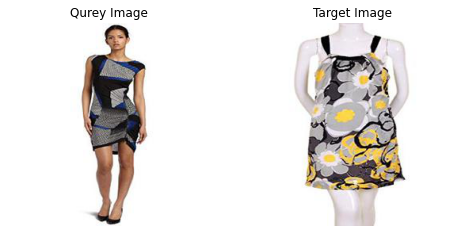

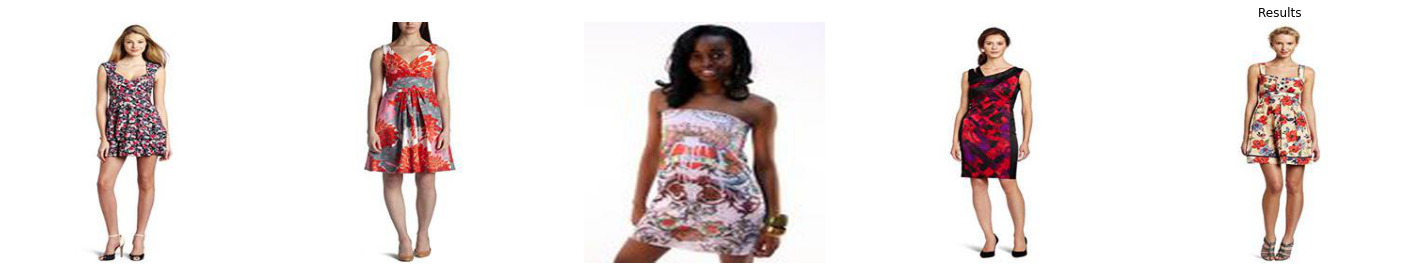

In [ ]:
show_source(100),show_result_all(get_result(nn_result_TextOnly[100]))

# **img Only Efficient-Net**

In [ ]:
def parse_opt():
  """Parses the input arguments."""
  parser = argparse.ArgumentParser()
  parser.add_argument('-f', type=str, default='')
  parser.add_argument('--dataset', type=str, default='fashioniq')
  parser.add_argument('--root_dir', type=str, default='./{}')
  parser.add_argument('--log_dir', type=str, default='./runs')
  parser.add_argument('--model', type=str, default='imgonly')
  parser.add_argument('--img_encoder', type=str, default='efficientnet')
  parser.add_argument('--text_encoder', type=str, default='lstm')
  parser.add_argument('--embed_dim', type=int, default=1024)
  parser.add_argument('--optimizer', type=str, default='Adam') # SGD Adam
  parser.add_argument('--learning_rate', type=float, default=1e-4)
  parser.add_argument(
      '--learning_rate_decay_patient', type=int, default=5)
  parser.add_argument('--eval_frequency', type=int, default=1)
  parser.add_argument('--lr_div', type=float, default=0.5) # 0.1
  parser.add_argument('--batch_size', type=int, default=32)
  parser.add_argument('--weight_decay', type=float, default=1e-6)
  parser.add_argument('--num_epoch', type=int, default=15)
  parser.add_argument('--loss', type=str, default='batch_based_classification')
  parser.add_argument('--loader_num_workers', type=int, default=4)
  parser.add_argument('--resume_file', default='./runs/best_checkpoint.pth')
  
  args = parser.parse_args()
  return args
opt = parse_opt()

Training

In [ ]:
model, optimizer = create_model_and_optimizer(opt, None)

start_time = time.time()
df_loss_ImgOnly_Effi, df_R_mean_ImgOnly_Effi= train_loop(opt, logger, trainset, model, optimizer)    
Dress_time.append(time.time() - start_time)
logger.close()
df_loss_ImgOnly_Effi.head()


Creating model and optimizer for imgonly
Loaded pretrained weights for efficientnet-b0


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Begin training


Training for epoch 0: 100%|██████████| 187/187 [04:04<00:00,  1.31s/it]


It 187 epoch 0 Elapsed time 244.2722
    Loss batch_based_classification 3.1217
    Loss total training loss 3.1217


100%|██████████| 4197/4197 [00:25<00:00, 167.50it/s]


     dress_r1 1.41
     dress_r3 3.21
     dress_r5 4.49
     dress_r10 6.28
     dress_r20 9.49
     dress_r50 15.77
     rmean 6.77


Training for epoch 1: 100%|██████████| 187/187 [04:04<00:00,  1.31s/it]


It 374 epoch 1 Elapsed time 275.127
    Loss batch_based_classification 2.7917
    Loss total training loss 2.7917


100%|██████████| 4197/4197 [00:25<00:00, 167.67it/s]


     dress_r1 2.31
     dress_r3 4.87
     dress_r5 6.28
     dress_r10 8.72
     dress_r20 13.97
     dress_r50 21.67
     rmean 9.64


Training for epoch 2: 100%|██████████| 187/187 [04:04<00:00,  1.31s/it]


It 561 epoch 2 Elapsed time 274.8752
    Loss batch_based_classification 2.5575
    Loss total training loss 2.5575


100%|██████████| 4197/4197 [00:25<00:00, 166.87it/s]


     dress_r1 2.44
     dress_r3 6.03
     dress_r5 9.36
     dress_r10 13.08
     dress_r20 17.56
     dress_r50 26.28
     rmean 12.46


Training for epoch 3: 100%|██████████| 187/187 [04:04<00:00,  1.31s/it]


It 748 epoch 3 Elapsed time 275.1253
    Loss batch_based_classification 2.387
    Loss total training loss 2.387


100%|██████████| 4197/4197 [00:25<00:00, 166.44it/s]


     dress_r1 3.59
     dress_r3 8.46
     dress_r5 10.38
     dress_r10 14.23
     dress_r20 20.26
     dress_r50 32.31
     rmean 14.87


Training for epoch 4: 100%|██████████| 187/187 [04:04<00:00,  1.31s/it]


It 935 epoch 4 Elapsed time 275.2712
    Loss batch_based_classification 2.1915
    Loss total training loss 2.1915


100%|██████████| 4197/4197 [00:24<00:00, 168.00it/s]


     dress_r1 3.97
     dress_r3 9.23
     dress_r5 13.33
     dress_r10 17.82
     dress_r20 24.62
     dress_r50 36.03
     rmean 17.5


Training for epoch 5: 100%|██████████| 187/187 [04:04<00:00,  1.31s/it]


It 1122 epoch 5 Elapsed time 274.7069
    Loss batch_based_classification 2.0442
    Loss total training loss 2.0442


100%|██████████| 4197/4197 [00:24<00:00, 168.26it/s]


     dress_r1 5.0
     dress_r3 10.38
     dress_r5 14.36
     dress_r10 19.62
     dress_r20 28.46
     dress_r50 41.79
     rmean 19.94


Training for epoch 6: 100%|██████████| 187/187 [04:04<00:00,  1.31s/it]


It 1309 epoch 6 Elapsed time 274.6614
    Loss batch_based_classification 1.8873
    Loss total training loss 1.8873


100%|██████████| 4197/4197 [00:24<00:00, 168.60it/s]


     dress_r1 6.54
     dress_r3 12.82
     dress_r5 18.21
     dress_r10 24.23
     dress_r20 34.49
     dress_r50 51.54
     rmean 24.64


Training for epoch 7: 100%|██████████| 187/187 [04:04<00:00,  1.31s/it]


It 1496 epoch 7 Elapsed time 274.7664
    Loss batch_based_classification 1.756
    Loss total training loss 1.756


100%|██████████| 4197/4197 [00:24<00:00, 168.21it/s]


     dress_r1 7.56
     dress_r3 15.51
     dress_r5 19.87
     dress_r10 28.21
     dress_r20 37.82
     dress_r50 55.38
     rmean 27.39


Training for epoch 8: 100%|██████████| 187/187 [04:04<00:00,  1.31s/it]


It 1683 epoch 8 Elapsed time 274.7427
    Loss batch_based_classification 1.6238
    Loss total training loss 1.6238


100%|██████████| 4197/4197 [00:24<00:00, 168.86it/s]


     dress_r1 9.74
     dress_r3 17.31
     dress_r5 22.69
     dress_r10 33.21
     dress_r20 45.64
     dress_r50 61.03
     rmean 31.6


Training for epoch 9: 100%|██████████| 187/187 [04:04<00:00,  1.31s/it]


It 1870 epoch 9 Elapsed time 274.6075
    Loss batch_based_classification 1.5078
    Loss total training loss 1.5078


100%|██████████| 4197/4197 [00:24<00:00, 168.20it/s]


     dress_r1 10.9
     dress_r3 21.79
     dress_r5 29.1
     dress_r10 38.59
     dress_r20 50.9
     dress_r50 66.92
     rmean 36.37


Training for epoch 10: 100%|██████████| 187/187 [04:04<00:00,  1.31s/it]


It 2057 epoch 10 Elapsed time 274.6184
    Loss batch_based_classification 1.3848
    Loss total training loss 1.3848


100%|██████████| 4197/4197 [00:24<00:00, 168.71it/s]


     dress_r1 11.28
     dress_r3 22.69
     dress_r5 31.15
     dress_r10 41.79
     dress_r20 55.0
     dress_r50 72.69
     rmean 39.1


Training for epoch 11: 100%|██████████| 187/187 [04:04<00:00,  1.31s/it]


It 2244 epoch 11 Elapsed time 274.7784
    Loss batch_based_classification 1.269
    Loss total training loss 1.269


100%|██████████| 4197/4197 [00:24<00:00, 168.13it/s]


     dress_r1 14.23
     dress_r3 25.26
     dress_r5 35.64
     dress_r10 47.05
     dress_r20 61.79
     dress_r50 78.33
     rmean 43.72


Training for epoch 12: 100%|██████████| 187/187 [04:04<00:00,  1.31s/it]


It 2431 epoch 12 Elapsed time 274.8384
    Loss batch_based_classification 1.1852
    Loss total training loss 1.1852


100%|██████████| 4197/4197 [00:24<00:00, 168.29it/s]


     dress_r1 17.56
     dress_r3 31.15
     dress_r5 40.38
     dress_r10 52.18
     dress_r20 65.9
     dress_r50 80.51
     rmean 47.95


Training for epoch 13: 100%|██████████| 187/187 [04:04<00:00,  1.31s/it]


It 2618 epoch 13 Elapsed time 275.2105
    Loss batch_based_classification 1.0924
    Loss total training loss 1.0924


100%|██████████| 4197/4197 [00:25<00:00, 167.76it/s]


     dress_r1 16.41
     dress_r3 35.13
     dress_r5 43.33
     dress_r10 57.31
     dress_r20 69.62
     dress_r50 85.38
     rmean 51.2


Training for epoch 14: 100%|██████████| 187/187 [04:04<00:00,  1.31s/it]


It 2805 epoch 14 Elapsed time 275.4134
    Loss batch_based_classification 1.0127
    Loss total training loss 1.0127


100%|██████████| 4197/4197 [00:24<00:00, 168.31it/s]


     dress_r1 21.15
     dress_r3 36.79
     dress_r5 47.44
     dress_r10 61.28
     dress_r20 75.13
     dress_r50 87.82
     rmean 54.94
Finished training


,epoch,batch_based_classification,total training loss
0,0.0,3.12175,3.12175
1,1.0,2.79171,2.79171
2,2.0,2.55750,2.55750
3,3.0,2.38702,2.38702
4,4.0,2.19147,2.19147


In [ ]:
df_loss_ImgOnly_Effi

,epoch,batch_based_classification,total training loss
0,0.0,3.12175,3.12175
1,1.0,2.79171,2.79171
2,2.0,2.55750,2.55750
3,3.0,2.38702,2.38702
4,4.0,2.19147,2.19147
5,5.0,2.04417,2.04417
6,6.0,1.88733,1.88733
7,7.0,1.75603,1.75603
8,8.0,1.62378,1.62378
9,9.0,1.50784,1.50784


In [ ]:
df_R_mean_ImgOnly_Effi

,epoch,Recall_Mean
0,0.0,6.773504
1,1.0,9.636752
2,2.0,12.457265
3,3.0,14.871795
4,4.0,17.500000
5,5.0,19.935897
6,6.0,24.636752
7,7.0,27.393162
8,8.0,31.602564
9,9.0,36.367521


In [ ]:
Dress_time

[2729.2275133132935, 4123.589092731476]

**Testing**

In [ ]:
model, optimizer = create_model_and_optimizer(opt, None)
# state_dicts = torch.load(opt.resume_file, map_location=lambda storage, loc: storage)['model_state_dict']
# model.load_state_dict(state_dicts)
nn_result_ImgOnly_Effi=test(opt, testset, model)


Begin testing


100%|██████████| 1687/1687 [00:10<00:00, 168.51it/s]


     dress_r1 1.55
     dress_r3 2.07
     dress_r5 3.11
     dress_r10 4.92
     dress_r20 8.29
     dress_r50 14.77
     RecallMean 5.79
Finished testing


**Qualitative Results**

In [ ]:
test_queries = testset.get_test_queries()[0]
print(test_queries[1])

{'source_img_id': 1377, 'source_img_data': tensor([[[2.2489, 2.2489, 2.2489,  ..., 2.2489, 2.2489, 2.2489],
         [2.2489, 2.2489, 2.2489,  ..., 2.2489, 2.2489, 2.2489],
         [2.2489, 2.2489, 2.2489,  ..., 2.2489, 2.2489, 2.2489],
         ...,
         [2.2489, 2.2489, 2.2489,  ..., 2.2489, 2.2489, 2.2489],
         [2.2489, 2.2489, 2.2489,  ..., 2.2489, 2.2489, 2.2489],
         [2.2489, 2.2489, 2.2489,  ..., 2.2489, 2.2489, 2.2489]],

        [[2.4286, 2.4286, 2.4286,  ..., 2.4286, 2.4286, 2.4286],
         [2.4286, 2.4286, 2.4286,  ..., 2.4286, 2.4286, 2.4286],
         [2.4286, 2.4286, 2.4286,  ..., 2.4286, 2.4286, 2.4286],
         ...,
         [2.4286, 2.4286, 2.4286,  ..., 2.4286, 2.4286, 2.4286],
         [2.4286, 2.4286, 2.4286,  ..., 2.4286, 2.4286, 2.4286],
         [2.4286, 2.4286, 2.4286,  ..., 2.4286, 2.4286, 2.4286]],

        [[2.6400, 2.6400, 2.6400,  ..., 2.6400, 2.6400, 2.6400],
         [2.6400, 2.6400, 2.6400,  ..., 2.6400, 2.6400, 2.6400],
         [2.640

Textual Query =     is more floral <AND> is more strappy and colorful  
50


(None, None)

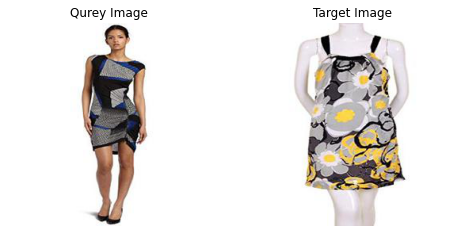

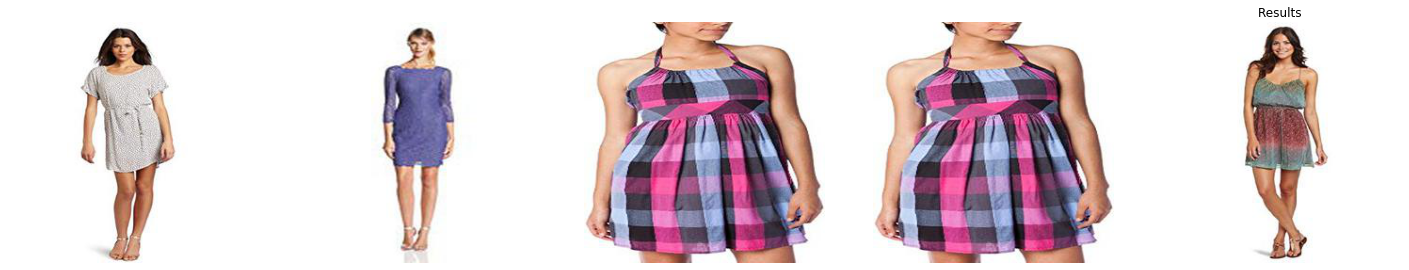

In [ ]:
show_source(100),show_result_all(get_result(nn_result_ImgOnly_Effi[100]))

Textual Query =     is sleeveless and stripes horizontally <AND> striped  
50


(None, None)

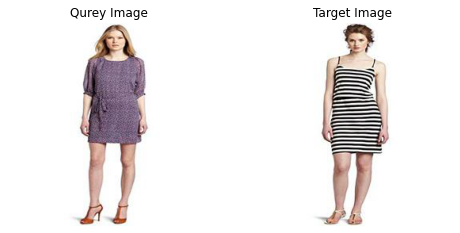

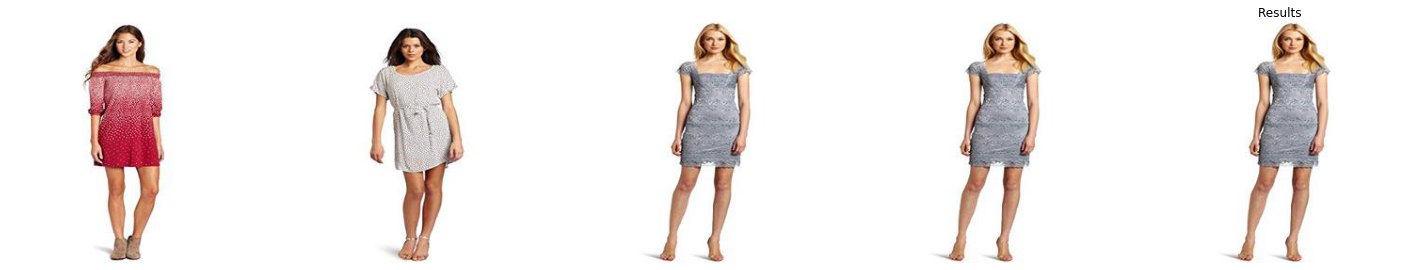

In [ ]:
show_source(65),show_result_all(get_result(nn_result_ImgOnly_Effi[65]))

Textual Query =     has thin straps and different pattern <AND> more autumn colored and longer  
50


(None, None)

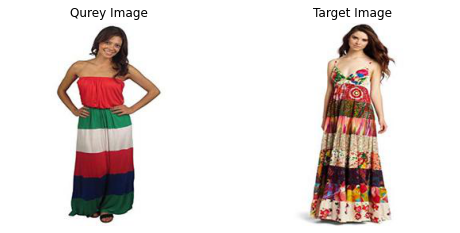

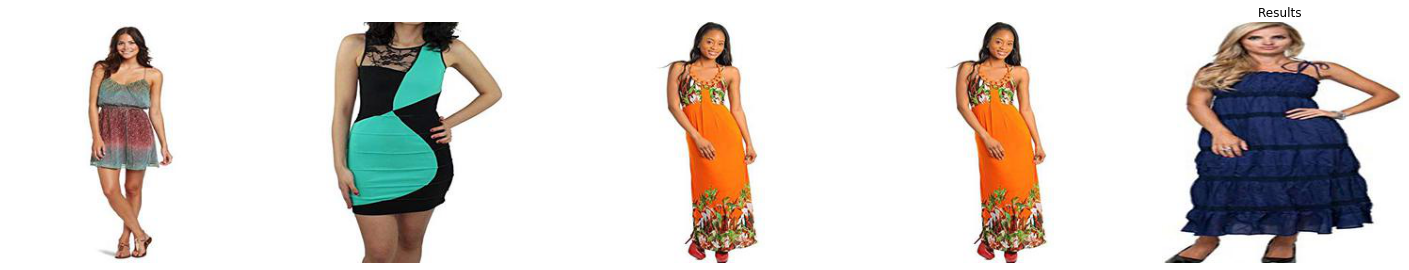

In [ ]:
show_source(1),show_result_all(get_result(nn_result_ImgOnly_Effi[1]))

# **Image Only ResNet 50**

In [ ]:
def parse_opt():
  """Parses the input arguments."""
  parser = argparse.ArgumentParser()
  parser.add_argument('-f', type=str, default='')
  parser.add_argument('--dataset', type=str, default='fashioniq')
  parser.add_argument('--root_dir', type=str, default='./{}')
  parser.add_argument('--log_dir', type=str, default='./runs')
  parser.add_argument('--model', type=str, default='imgonly')
  parser.add_argument('--img_encoder', type=str, default='resnet50')
  parser.add_argument('--text_encoder', type=str, default='lstm')
  parser.add_argument('--embed_dim', type=int, default=1024)
  parser.add_argument('--optimizer', type=str, default='Adam') # SGD Adam
  parser.add_argument('--learning_rate', type=float, default=1e-4)
  parser.add_argument(
      '--learning_rate_decay_patient', type=int, default=5)
  parser.add_argument('--eval_frequency', type=int, default=1)
  parser.add_argument('--lr_div', type=float, default=0.5) # 0.1
  parser.add_argument('--batch_size', type=int, default=32)
  parser.add_argument('--weight_decay', type=float, default=1e-6)
  parser.add_argument('--num_epoch', type=int, default=15)
  parser.add_argument('--loss', type=str, default='batch_based_classification')
  parser.add_argument('--loader_num_workers', type=int, default=4)
  parser.add_argument('--resume_file', default='./runs/best_checkpoint.pth')
  
  args = parser.parse_args()
  return args
opt = parse_opt()

Training

In [ ]:
model, optimizer = create_model_and_optimizer(opt, None)

start_time = time.time()
df_loss_ImgOnly_res, df_R_mean_ImgOnly_res= train_loop(opt, logger, trainset, model, optimizer)    
Dress_time.append(time.time() - start_time)
logger.close()
df_loss_ImgOnly_res.head()


Creating model and optimizer for imgonly


Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Begin training


Training for epoch 0: 100%|██████████| 187/187 [05:14<00:00,  1.68s/it]


It 187 epoch 0 Elapsed time 314.3393
    Loss batch_based_classification 2.9776
    Loss total training loss 2.9776


100%|██████████| 4197/4197 [00:36<00:00, 115.96it/s]


     dress_r1 1.79
     dress_r3 3.59
     dress_r5 4.36
     dress_r10 6.67
     dress_r20 9.74
     dress_r50 16.54
     rmean 7.12


Training for epoch 1: 100%|██████████| 187/187 [05:13<00:00,  1.68s/it]


It 374 epoch 1 Elapsed time 358.1694
    Loss batch_based_classification 2.6754
    Loss total training loss 2.6754


100%|██████████| 4197/4197 [00:36<00:00, 116.57it/s]


     dress_r1 1.79
     dress_r3 4.23
     dress_r5 5.51
     dress_r10 8.46
     dress_r20 13.08
     dress_r50 20.77
     rmean 8.97


Training for epoch 2: 100%|██████████| 187/187 [05:14<00:00,  1.68s/it]


It 561 epoch 2 Elapsed time 358.3705
    Loss batch_based_classification 2.4687
    Loss total training loss 2.4687


100%|██████████| 4197/4197 [00:36<00:00, 116.44it/s]


     dress_r1 2.31
     dress_r3 4.74
     dress_r5 6.41
     dress_r10 9.36
     dress_r20 13.97
     dress_r50 25.38
     rmean 10.36


Training for epoch 3: 100%|██████████| 187/187 [05:14<00:00,  1.68s/it]


It 748 epoch 3 Elapsed time 358.1682
    Loss batch_based_classification 2.2733
    Loss total training loss 2.2733


100%|██████████| 4197/4197 [00:36<00:00, 115.09it/s]


     dress_r1 2.69
     dress_r3 6.67
     dress_r5 8.46
     dress_r10 12.56
     dress_r20 19.23
     dress_r50 29.23
     rmean 13.14


Training for epoch 4: 100%|██████████| 187/187 [05:14<00:00,  1.68s/it]


It 935 epoch 4 Elapsed time 358.6905
    Loss batch_based_classification 2.0855
    Loss total training loss 2.0855


100%|██████████| 4197/4197 [00:36<00:00, 115.37it/s]


     dress_r1 3.72
     dress_r3 7.82
     dress_r5 11.15
     dress_r10 17.95
     dress_r20 22.56
     dress_r50 36.54
     rmean 16.62


Training for epoch 5: 100%|██████████| 187/187 [05:13<00:00,  1.68s/it]


It 1122 epoch 5 Elapsed time 358.4316
    Loss batch_based_classification 1.8768
    Loss total training loss 1.8768


100%|██████████| 4197/4197 [00:36<00:00, 115.63it/s]


     dress_r1 4.49
     dress_r3 8.85
     dress_r5 11.03
     dress_r10 16.54
     dress_r20 24.36
     dress_r50 37.18
     rmean 17.07


Training for epoch 6: 100%|██████████| 187/187 [05:14<00:00,  1.68s/it]


It 1309 epoch 6 Elapsed time 358.7073
    Loss batch_based_classification 1.7242
    Loss total training loss 1.7242


100%|██████████| 4197/4197 [00:36<00:00, 115.10it/s]


     dress_r1 5.51
     dress_r3 11.03
     dress_r5 14.74
     dress_r10 21.03
     dress_r20 30.26
     dress_r50 47.44
     rmean 21.67


Training for epoch 7: 100%|██████████| 187/187 [05:14<00:00,  1.68s/it]


It 1496 epoch 7 Elapsed time 358.6574
    Loss batch_based_classification 1.5146
    Loss total training loss 1.5146


100%|██████████| 4197/4197 [00:36<00:00, 115.37it/s]


     dress_r1 6.15
     dress_r3 13.33
     dress_r5 18.59
     dress_r10 26.41
     dress_r20 35.77
     dress_r50 51.92
     rmean 25.36


Training for epoch 8: 100%|██████████| 187/187 [05:14<00:00,  1.68s/it]


It 1683 epoch 8 Elapsed time 358.8328
    Loss batch_based_classification 1.3288
    Loss total training loss 1.3288


100%|██████████| 4197/4197 [00:36<00:00, 115.18it/s]


     dress_r1 7.69
     dress_r3 16.54
     dress_r5 21.41
     dress_r10 30.26
     dress_r20 40.77
     dress_r50 59.1
     rmean 29.29


Training for epoch 9: 100%|██████████| 187/187 [05:14<00:00,  1.68s/it]


It 1870 epoch 9 Elapsed time 358.7611
    Loss batch_based_classification 1.1831
    Loss total training loss 1.1831


100%|██████████| 4197/4197 [00:36<00:00, 115.16it/s]


     dress_r1 9.62
     dress_r3 17.95
     dress_r5 25.0
     dress_r10 35.51
     dress_r20 47.18
     dress_r50 65.13
     rmean 33.4


Training for epoch 10: 100%|██████████| 187/187 [05:14<00:00,  1.68s/it]


It 2057 epoch 10 Elapsed time 358.8254
    Loss batch_based_classification 0.9751
    Loss total training loss 0.9751


100%|██████████| 4197/4197 [00:36<00:00, 115.19it/s]


     dress_r1 10.51
     dress_r3 21.41
     dress_r5 27.56
     dress_r10 40.51
     dress_r20 53.72
     dress_r50 70.51
     rmean 37.37


Training for epoch 11: 100%|██████████| 187/187 [05:14<00:00,  1.68s/it]


It 2244 epoch 11 Elapsed time 358.8097
    Loss batch_based_classification 0.843
    Loss total training loss 0.843


100%|██████████| 4197/4197 [00:36<00:00, 115.46it/s]


     dress_r1 11.67
     dress_r3 23.46
     dress_r5 29.74
     dress_r10 42.05
     dress_r20 58.33
     dress_r50 75.38
     rmean 40.11


Training for epoch 12: 100%|██████████| 187/187 [05:14<00:00,  1.68s/it]


It 2431 epoch 12 Elapsed time 358.6922
    Loss batch_based_classification 0.7285
    Loss total training loss 0.7285


100%|██████████| 4197/4197 [00:36<00:00, 115.32it/s]


     dress_r1 14.49
     dress_r3 29.87
     dress_r5 37.82
     dress_r10 51.41
     dress_r20 64.74
     dress_r50 80.26
     rmean 46.43


Training for epoch 13: 100%|██████████| 187/187 [05:13<00:00,  1.68s/it]


It 2618 epoch 13 Elapsed time 358.5348
    Loss batch_based_classification 0.6239
    Loss total training loss 0.6239


100%|██████████| 4197/4197 [00:36<00:00, 115.32it/s]


     dress_r1 18.21
     dress_r3 35.51
     dress_r5 45.0
     dress_r10 56.92
     dress_r20 69.87
     dress_r50 86.03
     rmean 51.92


Training for epoch 14: 100%|██████████| 187/187 [05:14<00:00,  1.68s/it]


It 2805 epoch 14 Elapsed time 358.7224
    Loss batch_based_classification 0.5279
    Loss total training loss 0.5279


100%|██████████| 4197/4197 [00:36<00:00, 115.33it/s]


     dress_r1 22.31
     dress_r3 41.92
     dress_r5 53.08
     dress_r10 66.54
     dress_r20 76.15
     dress_r50 91.41
     rmean 58.57
Finished training


,epoch,batch_based_classification,total training loss
0,0.0,2.97757,2.97757
1,1.0,2.67542,2.67542
2,2.0,2.46865,2.46865
3,3.0,2.27325,2.27325
4,4.0,2.08551,2.08551


In [ ]:
df_loss_ImgOnly_res

,epoch,batch_based_classification,total training loss
0,0.0,2.97757,2.97757
1,1.0,2.67542,2.67542
2,2.0,2.46865,2.46865
3,3.0,2.27325,2.27325
4,4.0,2.08551,2.08551
5,5.0,1.87678,1.87678
6,6.0,1.72416,1.72416
7,7.0,1.51455,1.51455
8,8.0,1.32885,1.32885
9,9.0,1.18306,1.18306


In [ ]:
df_R_mean_ImgOnly_res

,epoch,Recall_Mean
0,0.0,7.115385
1,1.0,8.974359
2,2.0,10.363248
3,3.0,13.141026
4,4.0,16.623932
5,5.0,17.072650
6,6.0,21.666667
7,7.0,25.363248
8,8.0,29.294872
9,9.0,33.397436


**Testing**

In [ ]:

model, optimizer = create_model_and_optimizer(opt, None)
# state_dicts = torch.load(opt.resume_file, map_location=lambda storage, loc: storage)['model_state_dict']
# model.load_state_dict(state_dicts)
nn_result_ImgOnly_res=test(opt, testset, model)


Begin testing


100%|██████████| 1687/1687 [00:14<00:00, 116.12it/s]

     dress_r1 0.78
     dress_r3 2.07
     dress_r5 3.11
     dress_r10 3.63
     dress_r20 6.99
     dress_r50 14.25
     RecallMean 5.14
Finished testing


**Qualitative Results**

Textual Query =     is more floral <AND> is more strappy and colorful  
50


(None, None)

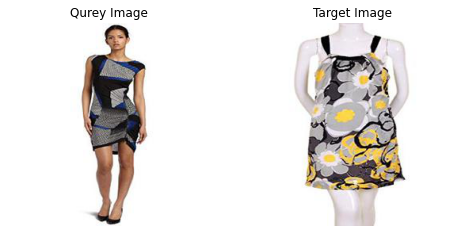

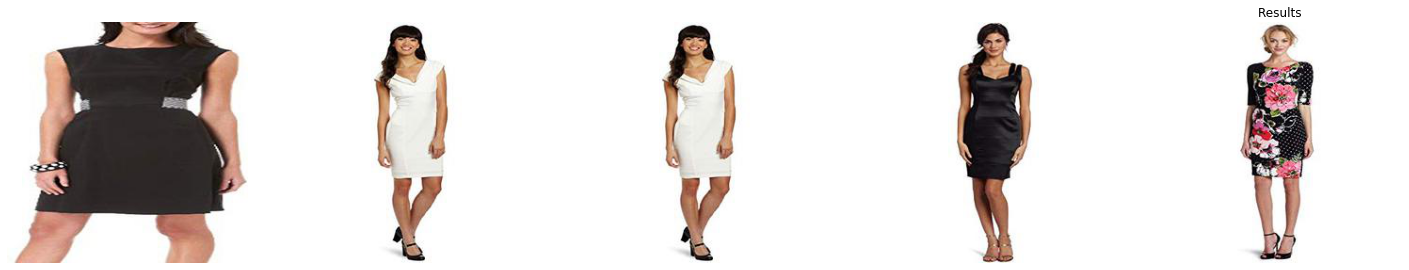

In [ ]:
show_source(100),show_result_all(get_result(nn_result_ImgOnly_res[100]))

Textual Query =     has thin straps and different pattern <AND> more autumn colored and longer  
50


(None, None)

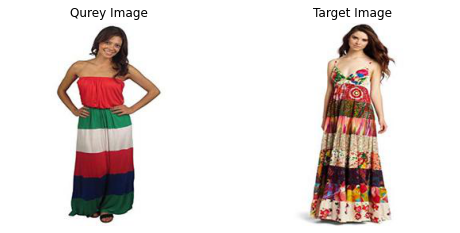

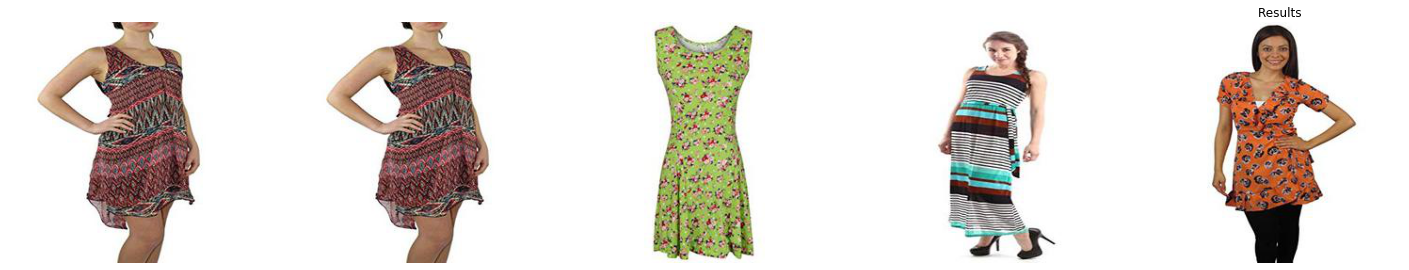

In [ ]:
show_source(1),show_result_all(get_result(nn_result_ImgOnly_res[1]))

# **TIRG**

In [ ]:
def parse_opt():
  """Parses the input arguments."""
  parser = argparse.ArgumentParser()
  parser.add_argument('-f', type=str, default='')
  parser.add_argument('--dataset', type=str, default='fashioniq')
  parser.add_argument('--root_dir', type=str, default='./{}')
  parser.add_argument('--log_dir', type=str, default='./runs')
  parser.add_argument('--model', type=str, default='tirg')
  parser.add_argument('--img_encoder', type=str, default='efficientnet')
  parser.add_argument('--text_encoder', type=str, default='lstm')
  parser.add_argument('--embed_dim', type=int, default=1024)
  parser.add_argument('--optimizer', type=str, default='Adam') # SGD Adam
  parser.add_argument('--learning_rate', type=float, default=1e-4)
  parser.add_argument(
      '--learning_rate_decay_patient', type=int, default=5)
  parser.add_argument('--eval_frequency', type=int, default=1)
  parser.add_argument('--lr_div', type=float, default=0.5) # 0.1
  parser.add_argument('--batch_size', type=int, default=32)
  parser.add_argument('--weight_decay', type=float, default=1e-6)
  parser.add_argument('--num_epoch', type=int, default=18)
  parser.add_argument('--loss', type=str, default='batch_based_classification')
  parser.add_argument('--loader_num_workers', type=int, default=2)
  #parser.add_argument('--is_test', default=False, action='store_true')
  #parser.add_argument('--return_test_rank', default=False, action='store_true')
  #parser.add_argument('--resume_file', default=None)
  parser.add_argument('--resume_file', default='./runs/best_checkpoint.pth')
  
  args = parser.parse_args()
  return args
opt = parse_opt()

Training

In [ ]:
model, optimizer = create_model_and_optimizer(opt, None)

start_time = time.time()
df_loss_tirg, df_R_mean_tirg= train_loop(opt, logger, trainset, model, optimizer)    
Dress_time.append(time.time() - start_time)
print("Total Time",Dress_time)
logger.close()
df_loss_tirg.head()



Creating model and optimizer for tirg
Loaded pretrained weights for efficientnet-b0
Begin training


Training for epoch 0: 100%|██████████| 187/187 [03:19<00:00,  1.07s/it]


It 187 epoch 0 Elapsed time 199.5648
    Loss batch_based_classification 2.8741
    Loss total training loss 2.8741


100%|██████████| 4197/4197 [00:19<00:00, 213.64it/s]


     dress_r1 2.31
     dress_r3 5.13
     dress_r5 7.18
     dress_r10 12.44
     dress_r20 18.72
     dress_r50 28.97
     rmean 12.46


Training for epoch 1: 100%|██████████| 187/187 [03:19<00:00,  1.07s/it]


It 374 epoch 1 Elapsed time 228.1229
    Loss batch_based_classification 2.0322
    Loss total training loss 2.0322


100%|██████████| 4197/4197 [00:19<00:00, 214.80it/s]


     dress_r1 5.0
     dress_r3 10.0
     dress_r5 13.08
     dress_r10 19.49
     dress_r20 28.59
     dress_r50 45.77
     rmean 20.32


Training for epoch 2: 100%|██████████| 187/187 [03:19<00:00,  1.07s/it]


It 561 epoch 2 Elapsed time 224.2117
    Loss batch_based_classification 1.5884
    Loss total training loss 1.5884


100%|██████████| 4197/4197 [00:19<00:00, 214.37it/s]


     dress_r1 7.18
     dress_r3 17.18
     dress_r5 21.15
     dress_r10 29.62
     dress_r20 42.05
     dress_r50 61.28
     rmean 29.74


Training for epoch 3: 100%|██████████| 187/187 [03:19<00:00,  1.07s/it]


It 748 epoch 3 Elapsed time 223.999
    Loss batch_based_classification 1.3115
    Loss total training loss 1.3115


100%|██████████| 4197/4197 [00:19<00:00, 215.52it/s]


     dress_r1 11.28
     dress_r3 21.67
     dress_r5 28.21
     dress_r10 39.36
     dress_r20 53.21
     dress_r50 71.67
     rmean 37.56


Training for epoch 4: 100%|██████████| 187/187 [03:19<00:00,  1.06s/it]


It 935 epoch 4 Elapsed time 223.5571
    Loss batch_based_classification 1.0627
    Loss total training loss 1.0627


100%|██████████| 4197/4197 [00:19<00:00, 215.61it/s]


     dress_r1 13.21
     dress_r3 25.26
     dress_r5 33.72
     dress_r10 46.54
     dress_r20 59.36
     dress_r50 78.21
     rmean 42.71


Training for epoch 5: 100%|██████████| 187/187 [03:19<00:00,  1.06s/it]


It 1122 epoch 5 Elapsed time 223.5787
    Loss batch_based_classification 0.8914
    Loss total training loss 0.8914


100%|██████████| 4197/4197 [00:19<00:00, 215.83it/s]


     dress_r1 17.69
     dress_r3 31.03
     dress_r5 39.49
     dress_r10 52.69
     dress_r20 68.59
     dress_r50 84.74
     rmean 49.04


Training for epoch 6: 100%|██████████| 187/187 [03:19<00:00,  1.06s/it]


It 1309 epoch 6 Elapsed time 223.5383
    Loss batch_based_classification 0.7593
    Loss total training loss 0.7593


100%|██████████| 4197/4197 [00:19<00:00, 215.91it/s]


     dress_r1 23.72
     dress_r3 39.49
     dress_r5 49.87
     dress_r10 63.72
     dress_r20 77.44
     dress_r50 91.15
     rmean 57.56


Training for epoch 7: 100%|██████████| 187/187 [03:18<00:00,  1.06s/it]


It 1496 epoch 7 Elapsed time 222.6502
    Loss batch_based_classification 0.6432
    Loss total training loss 0.6432


100%|██████████| 4197/4197 [00:19<00:00, 216.88it/s]


     dress_r1 29.36
     dress_r3 47.44
     dress_r5 57.31
     dress_r10 71.92
     dress_r20 84.1
     dress_r50 93.33
     rmean 63.91


Training for epoch 8: 100%|██████████| 187/187 [03:18<00:00,  1.06s/it]


It 1683 epoch 8 Elapsed time 222.8869
    Loss batch_based_classification 0.5364
    Loss total training loss 0.5364


100%|██████████| 4197/4197 [00:19<00:00, 216.67it/s]


     dress_r1 34.62
     dress_r3 56.28
     dress_r5 65.51
     dress_r10 78.21
     dress_r20 88.08
     dress_r50 96.79
     rmean 69.91


Training for epoch 9: 100%|██████████| 187/187 [03:18<00:00,  1.06s/it]


It 1870 epoch 9 Elapsed time 222.7696
    Loss batch_based_classification 0.484
    Loss total training loss 0.484


100%|██████████| 4197/4197 [00:19<00:00, 215.72it/s]


     dress_r1 38.21
     dress_r3 60.64
     dress_r5 71.03
     dress_r10 83.08
     dress_r20 91.92
     dress_r50 97.31
     rmean 73.7


Training for epoch 10: 100%|██████████| 187/187 [03:18<00:00,  1.06s/it]


It 2057 epoch 10 Elapsed time 223.2154
    Loss batch_based_classification 0.4164
    Loss total training loss 0.4164


100%|██████████| 4197/4197 [00:19<00:00, 216.60it/s]


     dress_r1 47.82
     dress_r3 70.77
     dress_r5 80.13
     dress_r10 87.31
     dress_r20 95.38
     dress_r50 99.1
     rmean 80.09


Training for epoch 11: 100%|██████████| 187/187 [03:18<00:00,  1.06s/it]


It 2244 epoch 11 Elapsed time 222.919
    Loss batch_based_classification 0.3743
    Loss total training loss 0.3743


100%|██████████| 4197/4197 [00:19<00:00, 216.61it/s]


     dress_r1 53.08
     dress_r3 75.13
     dress_r5 82.56
     dress_r10 91.67
     dress_r20 97.05
     dress_r50 99.36
     rmean 83.14


Training for epoch 12: 100%|██████████| 187/187 [03:18<00:00,  1.06s/it]


It 2431 epoch 12 Elapsed time 223.1353
    Loss batch_based_classification 0.322
    Loss total training loss 0.322


100%|██████████| 4197/4197 [00:19<00:00, 216.79it/s]


     dress_r1 56.41
     dress_r3 79.49
     dress_r5 86.03
     dress_r10 93.46
     dress_r20 97.82
     dress_r50 99.62
     rmean 85.47


Training for epoch 13: 100%|██████████| 187/187 [03:18<00:00,  1.06s/it]


It 2618 epoch 13 Elapsed time 223.0572
    Loss batch_based_classification 0.2899
    Loss total training loss 0.2899


100%|██████████| 4197/4197 [00:19<00:00, 215.34it/s]


     dress_r1 61.15
     dress_r3 81.79
     dress_r5 88.33
     dress_r10 94.36
     dress_r20 98.21
     dress_r50 99.87
     rmean 87.29


Training for epoch 14: 100%|██████████| 187/187 [03:18<00:00,  1.06s/it]


It 2805 epoch 14 Elapsed time 223.0881
    Loss batch_based_classification 0.2505
    Loss total training loss 0.2505


100%|██████████| 4197/4197 [00:19<00:00, 215.97it/s]


     dress_r1 65.64
     dress_r3 85.26
     dress_r5 90.38
     dress_r10 96.28
     dress_r20 98.72
     dress_r50 99.74
     rmean 89.34


Training for epoch 15: 100%|██████████| 187/187 [03:18<00:00,  1.06s/it]


It 2992 epoch 15 Elapsed time 222.9877
    Loss batch_based_classification 0.2328
    Loss total training loss 0.2328


100%|██████████| 4197/4197 [00:19<00:00, 217.00it/s]


     dress_r1 69.1
     dress_r3 85.38
     dress_r5 91.28
     dress_r10 96.28
     dress_r20 98.97
     dress_r50 99.87
     rmean 90.15


Training for epoch 16: 100%|██████████| 187/187 [03:18<00:00,  1.06s/it]


It 3179 epoch 16 Elapsed time 222.9652
    Loss batch_based_classification 0.2185
    Loss total training loss 0.2185


100%|██████████| 4197/4197 [00:19<00:00, 217.60it/s]


     dress_r1 72.95
     dress_r3 90.26
     dress_r5 94.1
     dress_r10 98.08
     dress_r20 99.23
     dress_r50 99.87
     rmean 92.41


Training for epoch 17: 100%|██████████| 187/187 [03:18<00:00,  1.06s/it]


It 3366 epoch 17 Elapsed time 222.8215
    Loss batch_based_classification 0.205
    Loss total training loss 0.205


100%|██████████| 4197/4197 [00:19<00:00, 217.00it/s]


     dress_r1 73.33
     dress_r3 89.62
     dress_r5 93.59
     dress_r10 97.31
     dress_r20 99.49
     dress_r50 99.87
     rmean 92.2
Finished training
Total Time [4022.8242270946503]


,epoch,batch_based_classification,total training loss
0,0.0,2.87413,2.87413
1,1.0,2.03223,2.03223
2,2.0,1.58836,1.58836
3,3.0,1.31154,1.31154
4,4.0,1.06271,1.06271


In [ ]:
Dress_time

[4022.8242270946503]

In [ ]:
df_loss_tirg

,epoch,batch_based_classification,total training loss
0,0.0,2.87413,2.87413
1,1.0,2.03223,2.03223
2,2.0,1.58836,1.58836
3,3.0,1.31154,1.31154
4,4.0,1.06271,1.06271
5,5.0,0.89136,0.89136
6,6.0,0.75932,0.75932
7,7.0,0.64319,0.64319
8,8.0,0.53636,0.53636
9,9.0,0.48403,0.48403


In [ ]:
df_R_mean_tirg

,epoch,Recall_Mean
0,0.0,12.457265
1,1.0,20.320513
2,2.0,29.743590
3,3.0,37.564103
4,4.0,42.713675
5,5.0,49.038462
6,6.0,57.564103
7,7.0,63.910256
8,8.0,69.914530
9,9.0,73.696581


**Testing**

In [ ]:
model, optimizer = create_model_and_optimizer(opt, None)
# state_dicts = torch.load(opt.resume_file, map_location=lambda storage, loc: storage)['model_state_dict']
# model.load_state_dict(state_dicts)
nn_result_tirg=test(opt, testset, model)


Begin testing


100%|██████████| 1687/1687 [00:07<00:00, 215.32it/s]


     dress_r1 4.4
     dress_r3 11.92
     dress_r5 15.28
     dress_r10 22.02
     dress_r20 31.61
     dress_r50 47.67
     RecallMean 22.15
Finished testing


**Qualitative Results**

Textual Query =     is more floral <AND> is more strappy and colorful  
50


(None, None)

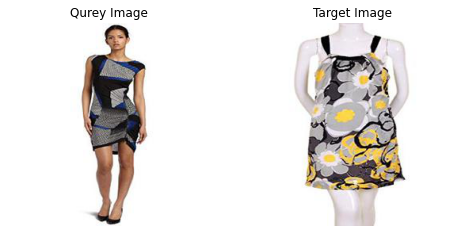

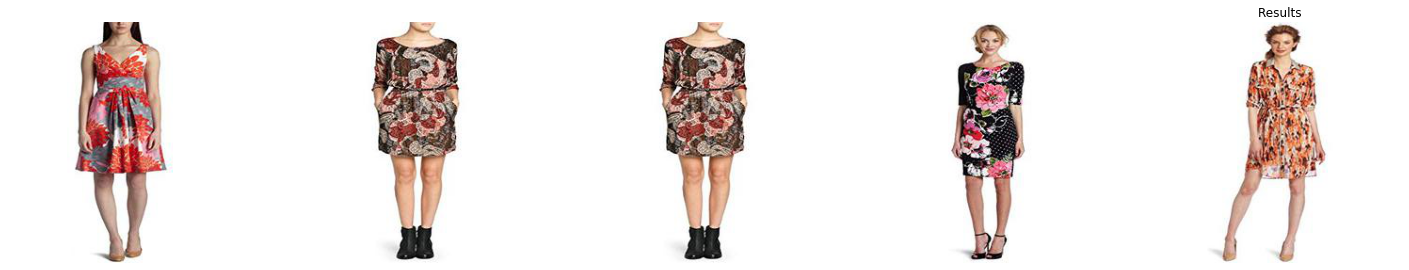

In [ ]:
show_source(100),show_result_all(get_result(nn_result_tirg[100]))

Textual Query =     has thin straps and different pattern <AND> more autumn colored and longer  
50


(None, None)

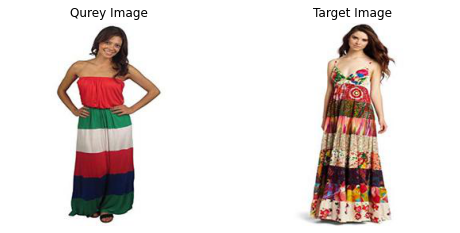

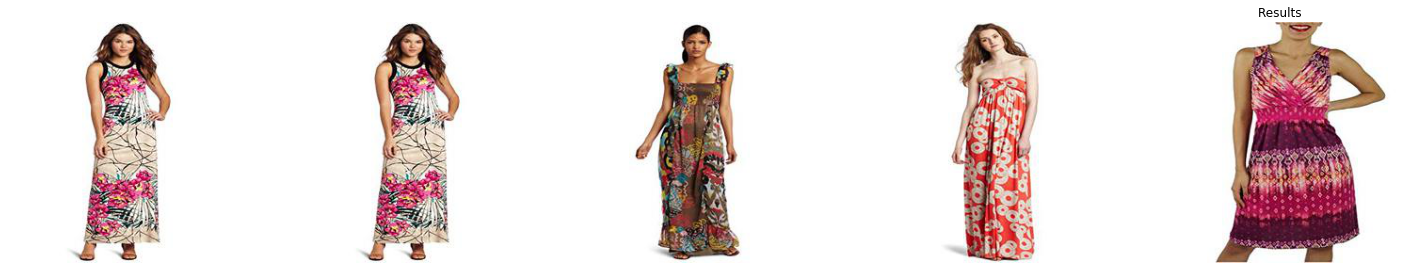

In [ ]:
show_source(1),show_result_all(get_result(nn_result_tirg[1]))

Textual Query =     is sleeveless and stripes horizontally <AND> striped  
50


(None, None)

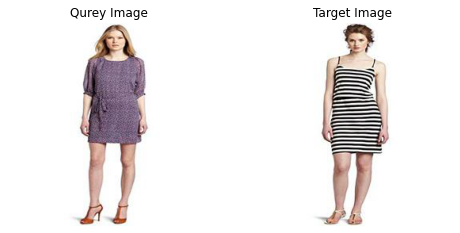

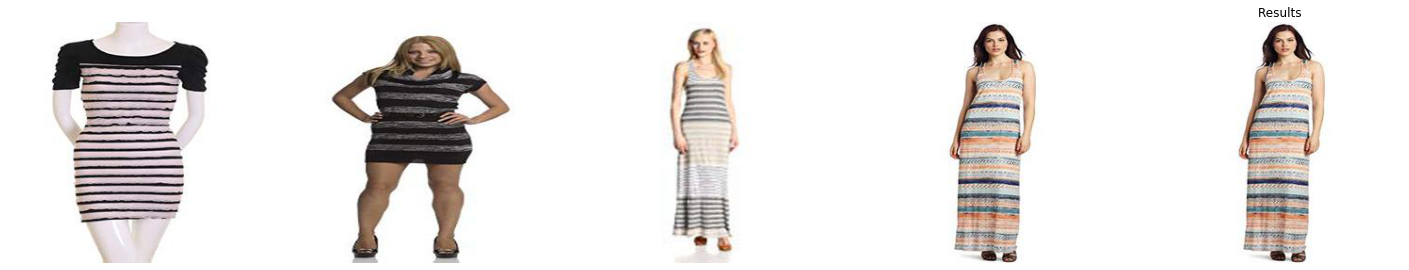

In [ ]:
show_source(65),show_result_all(get_result(nn_result_tirg[65]))

# Traning epoch vs losses

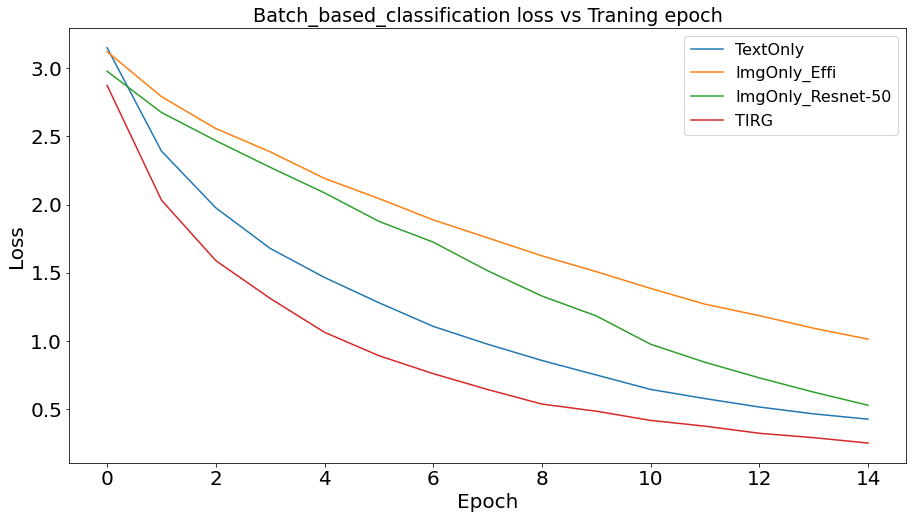

In [ ]:
#fig = figure(figsize = (15,10))
ax = plt.figure(figsize=(15,8)).gca()
plt.rcParams.update({'font.size': 16})
plt.plot(df_loss_TextOnly['epoch'], df_loss_TextOnly['batch_based_classification'], label = "TextOnly", linestyle="-")
plt.plot(df_loss_ImgOnly_Effi['epoch'], df_loss_ImgOnly_Effi['batch_based_classification'], label = "ImgOnly_Effi", linestyle="-")
plt.plot(df_loss_ImgOnly_res['epoch'], df_loss_ImgOnly_res['batch_based_classification'], label = "ImgOnly_Resnet-50", linestyle="-")
plt.plot(df_loss_tirg['epoch'], df_loss_tirg['batch_based_classification'], label = "TIRG", linestyle="-")
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Batch_based_classification loss vs Traning epoch")
plt.show()


# Recall Mean vs Training epoch

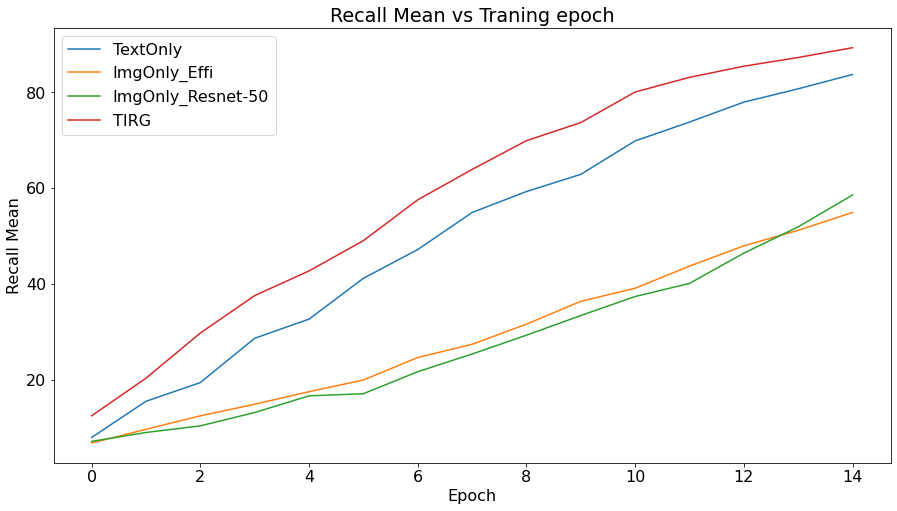

In [ ]:
ax = plt.figure(figsize=(15,8)).gca()
plt.rcParams.update({'font.size': 16})
plt.plot(df_R_mean_TextOnly['epoch'], df_R_mean_TextOnly['Recall_Mean'], label = "TextOnly", linestyle="-")
plt.plot(df_R_mean_ImgOnly_Effi['epoch'], df_R_mean_ImgOnly_Effi['Recall_Mean'], label = "ImgOnly_Effi", linestyle="-")
plt.plot(df_R_mean_ImgOnly_res['epoch'], df_R_mean_ImgOnly_res['Recall_Mean'], label = "ImgOnly_Resnet-50", linestyle="-")
plt.plot(df_R_mean_tirg['epoch'], df_R_mean_tirg['Recall_Mean'], label = "TIRG", linestyle="-")
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Recall Mean")
plt.title("Recall Mean vs Traning epoch")
plt.show()

# **plot Recall**

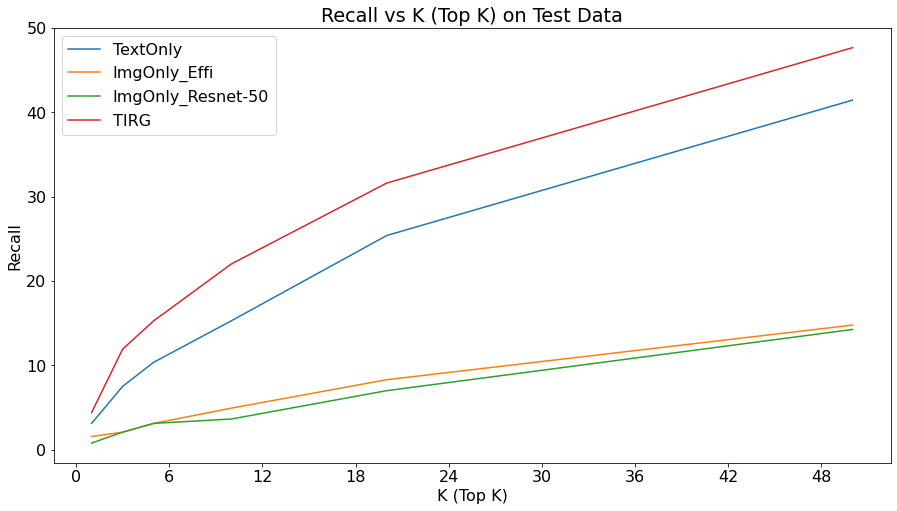

In [ ]:
Textonly= [3.11, 7.51, 10.36, 15.28, 25.39, 41.45]
Img_effi= [1.55, 2.07, 3.11, 4.92, 8.29, 14.77]
Img_res= [0.78, 2.07, 3.11, 3.63, 6.99, 14.25]
Tirg= [4.4, 11.92, 15.28, 22.02, 31.61, 47.67]
k=[1, 3, 5, 10, 20, 50]
#RecallMean= [17.18, 5.79, 5.14, 22.15]

ax = plt.figure(figsize=(15,8)).gca()
plt.rcParams.update({'font.size': 16})
plt.plot(k, Textonly, label = "TextOnly", linestyle="-")
plt.plot(k, Img_effi, label = "ImgOnly_Effi", linestyle="-")
plt.plot(k, Img_res, label = "ImgOnly_Resnet-50", linestyle="-")
plt.plot(k, Tirg, label = "TIRG", linestyle="-")
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
plt.legend()
plt.xlabel("K (Top K)")
plt.ylabel("Recall")
plt.title("Recall vs K (Top K) on Test Data")
plt.show()

No handles with labels found to put in legend.


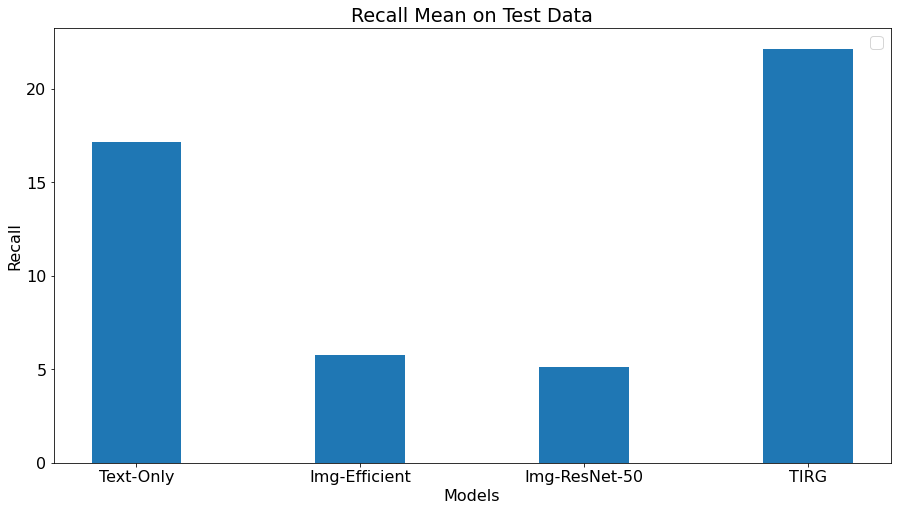

In [ ]:
X = ['Text-Only','Img-Efficient','Img-ResNet-50','TIRG']
RecallMean= [17.18, 5.79, 5.14, 22.15]  

ax = plt.figure(figsize=(15,8)).gca()
plt.rcParams.update({'font.size': 16})

X_axis = np.arange(len(X))
  
plt.bar(X_axis, RecallMean, 0.4)
  
plt.xticks(X_axis, X)
plt.xlabel("Models")
plt.ylabel("Recall")
plt.title("Recall Mean on Test Data")
plt.legend()
plt.show()